### Import das bibliotecas utilizadas

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

### Seleciona acelX, acelY, acelZ e atividade

In [2]:
df_andando = pd.read_csv("C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Andando-PausasNãoMarcadas.csv")
df_correndo = pd.read_excel("C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Todas_as_Corridas.xlsx")
df_caindo = pd.read_excel("C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Todas_as_Quedas.xlsx")

colunas_selecionadas = ['acelX', 'acelY', 'acelZ', 'idTipoMovimento']

df_andando   = df_andando[colunas_selecionadas]
df_caindo    = df_caindo[colunas_selecionadas]
df_correndo  = df_correndo[colunas_selecionadas]

df_andando['idTipoMovimento'] = 'Andando'
df_correndo['idTipoMovimento'] = 'Correndo'
df_caindo['idTipoMovimento'] = 'Caindo'

# Selecionando somente as 500 primeiras linhas de cada dataset
# df_andando   = df_andando.head(500)
# df_caindo    = df_caindo.head(500)
# df_correndo  = df_correndo.head(500)

### Mensurar volume do dataset

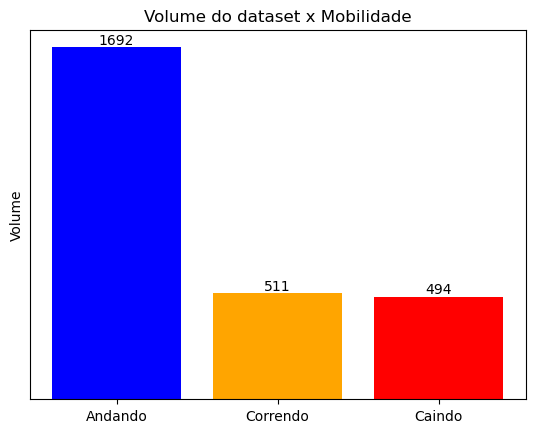

In [3]:
id_andando  = df_andando['idTipoMovimento'][0]
id_correndo = df_correndo['idTipoMovimento'][0]
id_caindo   = df_caindo['idTipoMovimento'][0]

eixo_x = [id_andando, id_correndo, id_caindo]
contagem = [len(df_andando),len(df_correndo),len(df_caindo)]
cores_barras = ['blue','orange','red']
legenda_barras = ['andando','correndo','caindo']

fig, ax = plt.subplots()

bar_container = ax.bar(eixo_x, contagem, label=legenda_barras, color=cores_barras)
ax.bar_label(bar_container, fmt='{:.0f}')
ax.set_title('Volume do dataset x Mobilidade')
# ax.set_xlabel('Mobilidade')
ax.set_ylabel('Volume')
# ax.legend()
plt.yticks([]) # Remover escala do eixo y
plt.xticks(eixo_x)
plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\volume_dataset_por_mobilidade.png')
plt.show()

### Adiciona cálculo da magnitude da aceleração

In [4]:
df_andando['MAGNITUDE_ACEL']   = np.sqrt(df_andando['acelX']**2 + df_andando['acelY']**2 + df_andando['acelZ']**2)
df_correndo['MAGNITUDE_ACEL']  = np.sqrt(df_correndo['acelX']**2 + df_correndo['acelY']**2 + df_correndo['acelZ']**2)
df_caindo['MAGNITUDE_ACEL']    = np.sqrt(df_caindo['acelX']**2 + df_caindo['acelY']**2 + df_caindo['acelZ']**2)


### Treinamento e teste do modelo (andando e correndo)

[[327   5]
 [  3 106]]
              precision    recall  f1-score   support

     Andando       0.99      0.98      0.99       332
    Correndo       0.95      0.97      0.96       109

    accuracy                           0.98       441
   macro avg       0.97      0.98      0.98       441
weighted avg       0.98      0.98      0.98       441



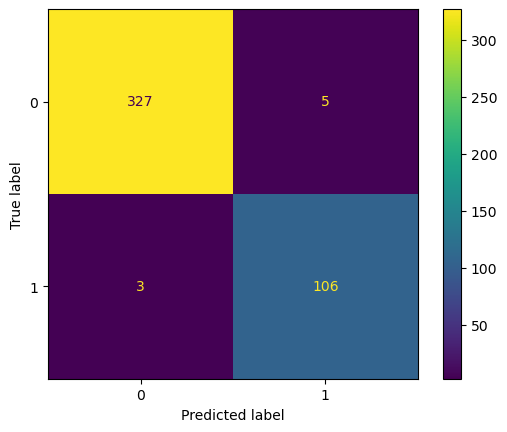

In [11]:
# df_andando_e_correndo = pd.concat([df_andando, df_correndo])

# X_train, X_test, y_train, y_test = train_test_split(df_andando_e_correndo[['acelX', 'acelY', 'acelZ', 'MAGNITUDE_ACEL']], df_andando_e_correndo['idTipoMovimento'], test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# tree = DecisionTreeClassifier(random_state=42)
# tree.fit(X_train, y_train)

# y_pred = tree.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\dt_matriz_confusao_andando_correndo.png', dpi=300, bbox_inches='tight')

### Treinamento e teste do modelo (andando e caindo)

[[330   6]
 [  8  94]]
              precision    recall  f1-score   support

     Andando       0.98      0.98      0.98       336
      Caindo       0.94      0.92      0.93       102

    accuracy                           0.97       438
   macro avg       0.96      0.95      0.95       438
weighted avg       0.97      0.97      0.97       438



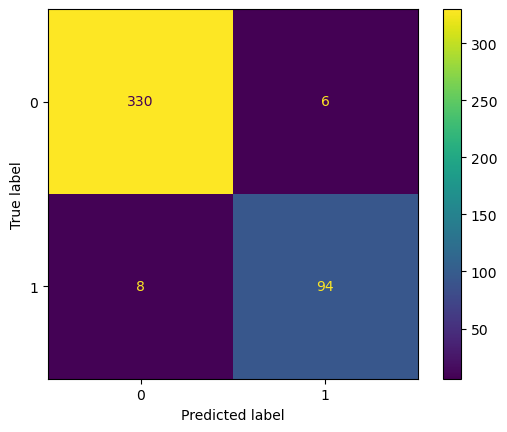

In [10]:
# df_andando_e_caindo = pd.concat([df_andando, df_caindo])

# X_train, X_test, y_train, y_test = train_test_split(df_andando_e_caindo[['acelX', 'acelY', 'acelZ', 'MAGNITUDE_ACEL']], df_andando_e_caindo['idTipoMovimento'], test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# tree = DecisionTreeClassifier(random_state=42)
# tree.fit(X_train, y_train)

# y_pred = tree.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\dt_matriz_confusao_andando_caindo.png', dpi=300, bbox_inches='tight')

### Treinamento e teste do modelo (correndo e caindo)

[[78 22]
 [22 79]]
              precision    recall  f1-score   support

      Caindo       0.78      0.78      0.78       100
    Correndo       0.78      0.78      0.78       101

    accuracy                           0.78       201
   macro avg       0.78      0.78      0.78       201
weighted avg       0.78      0.78      0.78       201



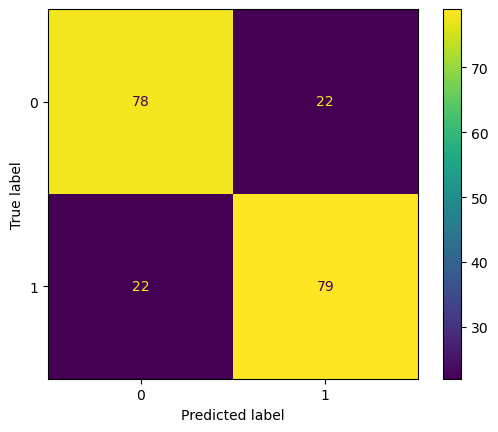

In [9]:
# df_correndo_e_caindo = pd.concat([df_correndo, df_caindo])

# X_train, X_test, y_train, y_test = train_test_split(df_correndo_e_caindo[['acelX', 'acelY', 'acelZ', 'MAGNITUDE_ACEL']], df_correndo_e_caindo['idTipoMovimento'], test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# tree = DecisionTreeClassifier(random_state=42)
# tree.fit(X_train, y_train)

# y_pred = tree.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\dt_matriz_confusao_correndo_e_caindo.png', dpi=300, bbox_inches='tight')

### Treinamento e teste do modelo (todos os movimentos)

[[338   7   2]
 [  5  68  21]
 [  2  21  76]]
              precision    recall  f1-score   support

     Andando       0.98      0.97      0.98       347
      Caindo       0.71      0.72      0.72        94
    Correndo       0.77      0.77      0.77        99

    accuracy                           0.89       540
   macro avg       0.82      0.82      0.82       540
weighted avg       0.89      0.89      0.89       540



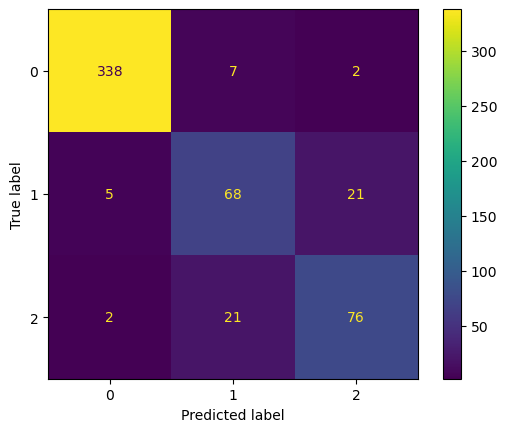

In [10]:
df_todos_os_movimentos = pd.concat([df_andando,df_correndo, df_caindo])

X_train, X_test, y_train, y_test = train_test_split(df_todos_os_movimentos[['acelX', 'acelY', 'acelZ', 'MAGNITUDE_ACEL']], df_todos_os_movimentos['idTipoMovimento'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\dt_matriz_confusao_todos_os_movimentos.png', dpi=300, bbox_inches='tight')

with open('modelos/dt_model.pkl', 'wb') as file:
    pickle.dump(tree, file)

In [11]:
df_teste_modelo = df_todos_os_movimentos
df_teste_modelo = df_teste_modelo.drop(columns=['idTipoMovimento'])
    
with open('modelos/dt_model.pkl', 'rb') as file:
    knn_loaded = pickle.load(file)
    
X_test = df_teste_modelo

y_pred = knn_loaded.predict(X_test)

print("Previsões: ", y_pred)

with open('predicoes/dt_predicoes.txt', 'w') as f:
    for pred in y_pred:
        f.write(f"{pred}\n")

print("Previsões salvas no arquivo 'predicoes/dt_predicoes.txt'")

Previsões:  ['Caindo' 'Caindo' 'Caindo' ... 'Caindo' 'Correndo' 'Caindo']
Previsões salvas no arquivo 'dt_predicoes.txt'


c:\Users\julia\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
